## Reading FILES

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mpd

from netCDF4 import Dataset as nc
from netCDF4 import num2date
import matplotlib.colors as colors
from datetime import datetime
from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## SIMPLE text files (data organize into columns)

In [2]:
filename='co2_mm_mlo.txt'
X=np.loadtxt(filename)
print(np.shape(X))
print(type(X))

(690, 7)
<class 'numpy.ndarray'>


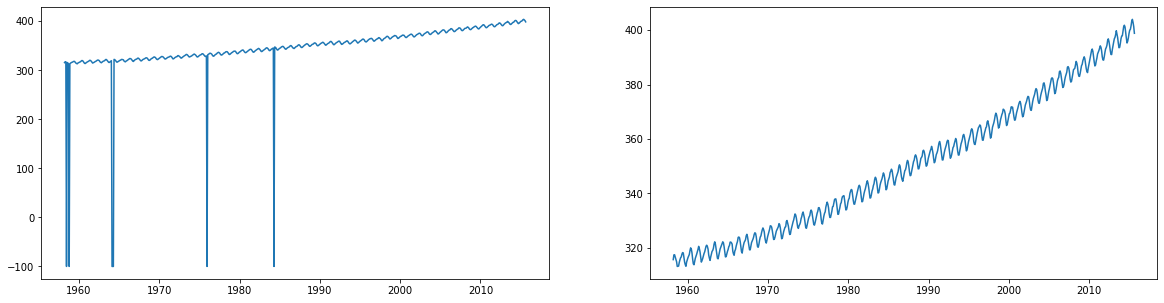

In [3]:
co2avg=X[:,3]
date=X[:,2]
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
ax1.plot(X[:,2],X[:,3])
ax2.plot(date[co2avg>-1],co2avg[co2avg>-1])

# Numpy Masked Arrays

In [4]:
co2avg_mask=np.ma.masked_where(X[:,3]<-1,co2avg)
print(type(co2avg_mask))
co2avg_mask[:4]

<class 'numpy.ma.core.MaskedArray'>


masked_array(data = [315.71 317.45 317.5 --],
             mask = [False False False  True],
       fill_value = 1e+20)

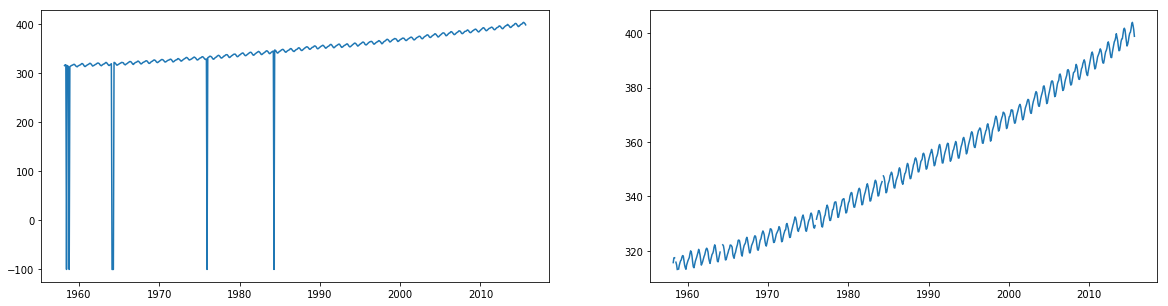

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
ax1.plot(X[:,2],X[:,3])
ax2.plot(X[:,2],co2avg_mask)

In [6]:
print(np.mean(co2avg[:4]))
print(np.mean(co2avg_mask[:4]))

212.6675
316.886666667


## Save and read data quickly

In [4]:
np.save('co2avg',co2avg)
B=np.load('co2avg.npy')

In [5]:
#1st way  to check that 2 arrays are the same
np.min(B==co2avg)
#2nd way  to check that 2 arrays are the same
np.max(np.abs(B-co2avg))

0.0

## Reading NETCDF files 

SST file on the Benguela Region

In [9]:
filesst='/Users/herbette/Cours/M1_Scientific_Programming/odyssea.nc'
#filesst='/Users/herbette/Cours/M1_Scientific_Programming/20170203-IFR-L4_GHRSST-SSTfnd-ODYSSEA-SAF_002-v2.0-fv1.0.nc'
ncf = nc(filesst, mode='r')
print(ncf.file_format)
print(ncf.dimensions.keys())
print(ncf.variables.keys())

NETCDF4
odict_keys(['lon', 'lat', 'time'])
odict_keys(['lon', 'lat', 'time', 'analysed_sst', 'analysis_error', 'mask', 'sea_ice_fraction'])


In [10]:
ncf = nc(filesst, mode='r')
lonsst = ncf['lon'][:]
latsst = ncf['lat'][:]
sstval=ncf['analysed_sst'][0]-273.15
ssterr=ncf['analysis_error'][0]
sstmask=ncf['mask'][0]
ncf.close()


In [11]:
print(np.shape(lonsst))
print(np.shape(latsst))

(400,)
(650,)


In [12]:
plt.pcolor(Latsst)

NameError: name 'Latsst' is not defined

In [13]:
Lonsst,Latsst=np.meshgrid(lonsst,latsst)
print(np.shape(Lonsst))
print(np.shape(Latsst))

(650, 400)
(650, 400)


In [14]:
print(np.shape(sstval))

(650, 400)


Some plotting

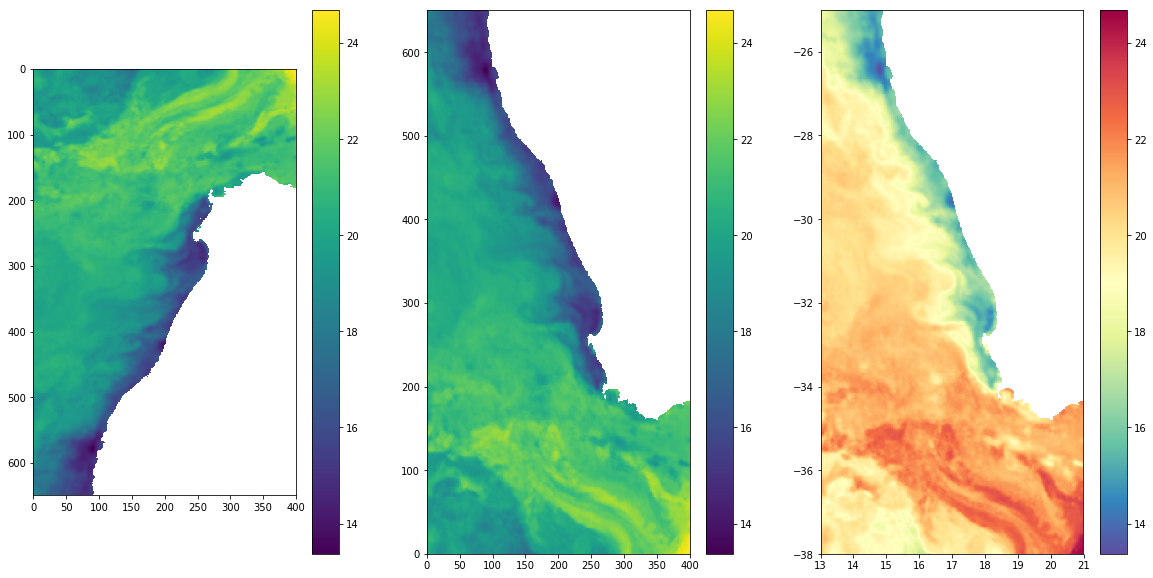

In [15]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
#fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
im1=ax1.imshow(sstval)
fig.colorbar(im1, ax=ax1)
im2=ax2.pcolor(sstval)
fig.colorbar(im2,ax=ax2)
im3=ax3.pcolor(Lonsst,Latsst,sstval,cmap=plt.cm.Spectral_r)
fig.colorbar(im3,ax=ax3)

Extract sub-domain

In [16]:
lonsub=lonsst[(lonsst>15)&(lonsst<18)]
latsub=latsst[(latsst>-34)&(latsst<-32)]
sstsub=sstval[(latsst>-34)&(latsst<-32),:][:,(lonsst>15)&(lonsst<18)]
Latsub=Latsst[(latsst>-34)&(latsst<-32),:][:,(lonsst>15)&(lonsst<18)]
Lonsub=Lonsst[(latsst>-34)&(latsst<-32),:][:,(lonsst>15)&(lonsst<18)]


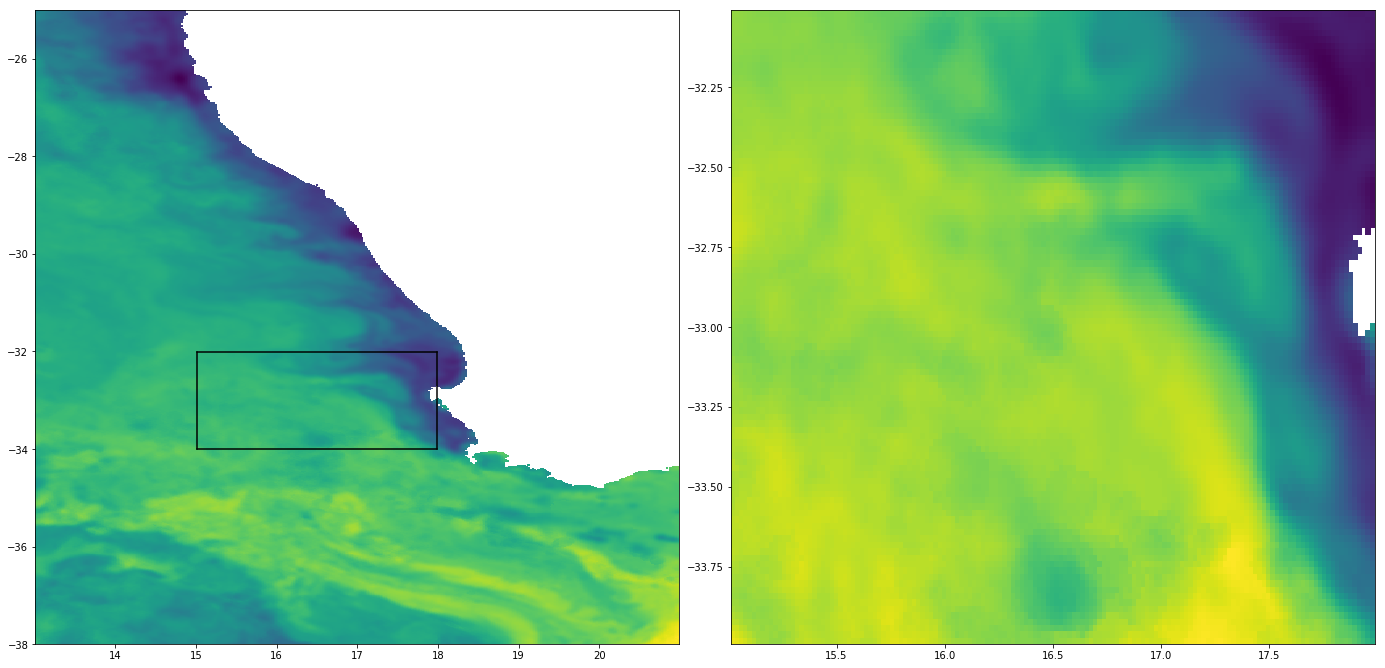

In [17]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.08)
im1=ax1.pcolor(Lonsst,Latsst,sstval)

min_lon2=np.min(Lonsub)
max_lon2=np.max(Lonsub)
min_lat2=np.min(Latsub)
max_lat2=np.max(Latsub)

ax1.plot(*zip(np.array((min_lon2,min_lat2)),np.array((min_lon2,max_lat2))),'k-')
ax1.plot(*zip(np.array((min_lon2,min_lat2)),np.array((max_lon2,min_lat2))),'k-')
ax1.plot(*zip(np.array((max_lon2,min_lat2)),np.array((max_lon2,max_lat2))),'k-')
ax1.plot(*zip(np.array((min_lon2,max_lat2)),np.array((max_lon2,max_lat2))),'k-')

im2=ax2.pcolor(Lonsub,Latsub,sstsub)



# Calculating gradient of SST

In [18]:
R= 6371.008*10**3
distx2=R*np.cos(latsst[:,np.newaxis]*np.pi/180)*(lonsst[np.newaxis,1:]-lonsst[np.newaxis,:-1])*np.pi/180

disty2=R*(latsst[1:,np.newaxis]-latsst[:-1,np.newaxis])*np.pi/180*np.ones((1,350))
print(disty2.shape)



(649, 350)


In [19]:
R= 6371.008*10**3
N=sstval.shape[0]
M=sstval.shape[1]
dsst_x=np.zeros((N,M-1))
for i in range(N):
    for j in range(M-1):
        dx=R*np.cos(0.5*(Latsst[i,j+1]+Latsst[i,j])*np.pi/180)*(Lonsst[i,j+1]-Lonsst[i,j])*np.pi/180
        dsst_x[i,j]=(sstval[i,j+1]-sstval[i,j])/dx

/Users/herbette/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [20]:
dsst_x2=np.zeros((N,M-1))
for j in range(M-1):
    dx=R*np.cos(0.5*(Latsst[:,j+1]+Latsst[:,j])*np.pi/180)*(Lonsst[:,j+1]-Lonsst[:,j])*np.pi/180
    dsst_x2[:,j]=(sstval[:,j+1]-sstval[:,j])/dx

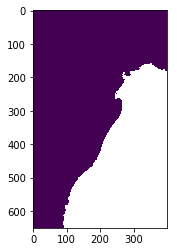

In [21]:
plt.imshow(np.abs(dsst_x2-dsst_x))

In [22]:
dsst_x3=np.zeros((N,M-1))
dx=R*np.cos(0.5*(Latsst[:,1:]+Latsst[:,:-1])*np.pi/180)*(Lonsst[:,1:]-Lonsst[:,:-1])*np.pi/180
dsst_x3=(sstval[:,1:]-sstval[:,:-1])/dx

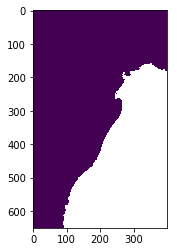

In [23]:
plt.imshow(np.abs(dsst_x3-dsst_x))

In [24]:
dsst_y=np.zeros((N-1,M))
for i in range(N-1):
    for j in range(M):
        dy=R*np.pi/180*(Latsst[i+1,j]-Latsst[i,j])
        dsst_y[i,j]=(sstval[i+1,j]-sstval[i,j])/dy

/Users/herbette/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [25]:
dsst_y2=np.zeros((N-1,M))
for i in range(N-1):
    dy=R*np.pi/180*(Latsst[i+1,:]-Latsst[i,:])
    dsst_y2[i,:]=(sstval[i+1,:]-sstval[i,:])/dy

In [26]:
dsst_y3=np.zeros((N-1,M))
dy=R*np.pi/180*(Latsst[1:,:]-Latsst[:-1,:])
dsst_y2=(sstval[1:,:]-sstval[:-1,:])/dy

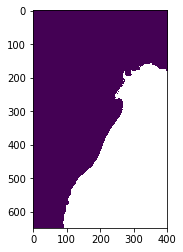

In [27]:
plt.imshow(dsst_y-dsst_y2)

In [28]:
dsst=np.sqrt((0.5*(dsst_x[1:,:]+dsst_x[:-1,:]))**2 +  (0.5*(dsst_y[:,1:]+dsst_y[:,:-1]))**2)

In [29]:
dsst.shape

(649, 399)

In [30]:
Longrad=0.25*(Lonsst[:-1,:-1]+Lonsst[:-1,1:]+Lonsst[1:,1:]+Lonsst[1:,:-1])
Latgrad=0.25*(Latsst[:-1,:-1]+Latsst[:-1,1:]+Latsst[1:,1:]+Latsst[1:,:-1])

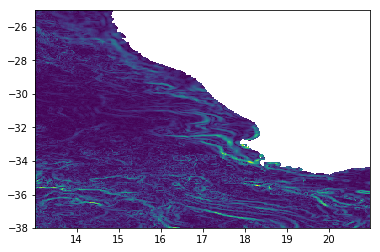

In [31]:
plt.pcolor(Longrad,Latgrad,dsst)

In [32]:
np.shape(Lonsst)

(650, 400)

In [33]:
np.shape(dsst)

(649, 399)

## Plotting Maps 

In [34]:
latcity = [-33.918861]
loncity = [18.423300]
cities = ['Cape Town']

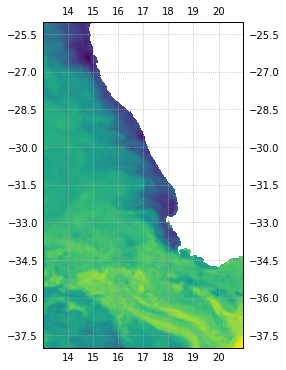

In [35]:
proj = ccrs.PlateCarree() 
fig = plt.figure(figsize=(10,6))
lonmin=np.min(Lonsst)
latmin=np.min(Latsst)
lonmax=np.max(Lonsst)
latmax=np.max(Latsst)
ax  = plt.axes(projection=proj,extent=[lonmin,lonmax,latmin,latmax])
ctf = ax.pcolor(Lonsst,Latsst,sstval)
ax.gridlines(linestyle=':',draw_labels=True) 

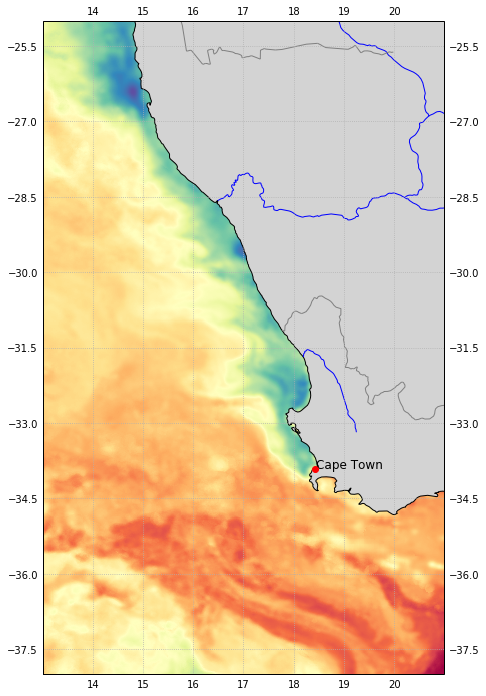

In [36]:
proj = ccrs.PlateCarree()                            # Choose the projection

cmap = plt.cm.get_cmap('Spectral_r')                 # Choose the colormap

land_10m = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='10m',
        edgecolor='k',
        facecolor='lightgrey')

states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
        scale='10m',
        edgecolor='gray',
        facecolor='none')

rivers = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        edgecolor='blue',
        facecolor='none')

lonmin=np.min(Lonsst)
latmin=np.min(Latsst)
lonmax=np.max(Lonsst)
latmax=np.max(Latsst)

fig = plt.figure(figsize=(20,12))
ax  = plt.axes(projection=proj,extent=[lonmin,lonmax,latmin,latmax])
#ax.add_feature(cfeature.LAND) # Land color
#ax.add_feature(cfeature.COASTLINE)# Add coastlines

ax.add_feature(land_10m)
ax.add_feature(rivers)
ax.add_feature(states_provinces)
ax.gridlines(linestyle=':',draw_labels=True)         # Add gridlines

for lon, lat, city in zip(loncity, latcity, cities):
    ax.plot(lon, lat, 'ro', zorder=5, transform=ccrs.PlateCarree())
    ax.text(lon + 0.01, lat + 0.01, city, fontsize='large',
                transform=ccrs.PlateCarree())


# ~ Plot SST
ctf = ax.pcolor(Lonsst,Latsst,sstval,cmap=cmap)


SST file on the Breizh Region

In [37]:
file='/Users/herbette/Clemence/Metop/20090601_103103-metop.nc'
ncf=nc(file,'r')
ncf.variables.keys()

odict_keys(['time', 'lon', 'lat', 'EUR_L2P_AVHRR_METOP_A_sst_dtime', 'EUR_L2P_AVHRR_METOP_A_time', 'EUR_L2P_AVHRR_METOP_A_lat', 'EUR_L2P_AVHRR_METOP_A_lon', 'EUR_L2P_AVHRR_METOP_A_sea_surface_temperature', 'EUR_L2P_AVHRR_METOP_A_SSES_bias_error', 'EUR_L2P_AVHRR_METOP_A_SSES_standard_deviation_error', 'EUR_L2P_AVHRR_METOP_A_satellite_zenith_angle', 'EUR_L2P_AVHRR_METOP_A_solar_zenith_angle', 'EUR_L2P_AVHRR_METOP_A_rejection_flag', 'EUR_L2P_AVHRR_METOP_A_confidence_flag', 'EUR_L2P_AVHRR_METOP_A_proximity_confidence', 'EUR_L2P_AVHRR_METOP_A_sea_ice_fraction', 'EUR_L2P_AVHRR_METOP_A_sources_of_sea_ice_fraction', 'EUR_L2P_AVHRR_METOP_A_aerosol_optical_depth', 'EUR_L2P_AVHRR_METOP_A_aod_dtime_from_sst', 'EUR_L2P_AVHRR_METOP_A_sources_of_aod', 'EUR_L2P_AVHRR_METOP_A_wind_speed', 'EUR_L2P_AVHRR_METOP_A_wind_speed_dtime_from_sst', 'EUR_L2P_AVHRR_METOP_A_sources_of_wind_speed', 'EUR_L2P_AVHRR_METOP_A_surface_solar_irradiance', 'EUR_L2P_AVHRR_METOP_A_ssi_dtime_from_sst', 'EUR_L2P_AVHRR_METOP_A_so

In [5]:
file='20090601_103103-metop.nc'

ncf=nc(file,'r')
lon = ncf.variables['lon'][:]
lat = ncf.variables['lat'][:]
sst=ncf.variables['EUR_L2P_AVHRR_METOP_A_sea_surface_temperature'][:]-273.15
ncf.variables.keys()

odict_keys(['time', 'lon', 'lat', 'EUR_L2P_AVHRR_METOP_A_sst_dtime', 'EUR_L2P_AVHRR_METOP_A_time', 'EUR_L2P_AVHRR_METOP_A_lat', 'EUR_L2P_AVHRR_METOP_A_lon', 'EUR_L2P_AVHRR_METOP_A_sea_surface_temperature', 'EUR_L2P_AVHRR_METOP_A_SSES_bias_error', 'EUR_L2P_AVHRR_METOP_A_SSES_standard_deviation_error', 'EUR_L2P_AVHRR_METOP_A_satellite_zenith_angle', 'EUR_L2P_AVHRR_METOP_A_solar_zenith_angle', 'EUR_L2P_AVHRR_METOP_A_rejection_flag', 'EUR_L2P_AVHRR_METOP_A_confidence_flag', 'EUR_L2P_AVHRR_METOP_A_proximity_confidence', 'EUR_L2P_AVHRR_METOP_A_sea_ice_fraction', 'EUR_L2P_AVHRR_METOP_A_sources_of_sea_ice_fraction', 'EUR_L2P_AVHRR_METOP_A_aerosol_optical_depth', 'EUR_L2P_AVHRR_METOP_A_aod_dtime_from_sst', 'EUR_L2P_AVHRR_METOP_A_sources_of_aod', 'EUR_L2P_AVHRR_METOP_A_wind_speed', 'EUR_L2P_AVHRR_METOP_A_wind_speed_dtime_from_sst', 'EUR_L2P_AVHRR_METOP_A_sources_of_wind_speed', 'EUR_L2P_AVHRR_METOP_A_surface_solar_irradiance', 'EUR_L2P_AVHRR_METOP_A_ssi_dtime_from_sst', 'EUR_L2P_AVHRR_METOP_A_so

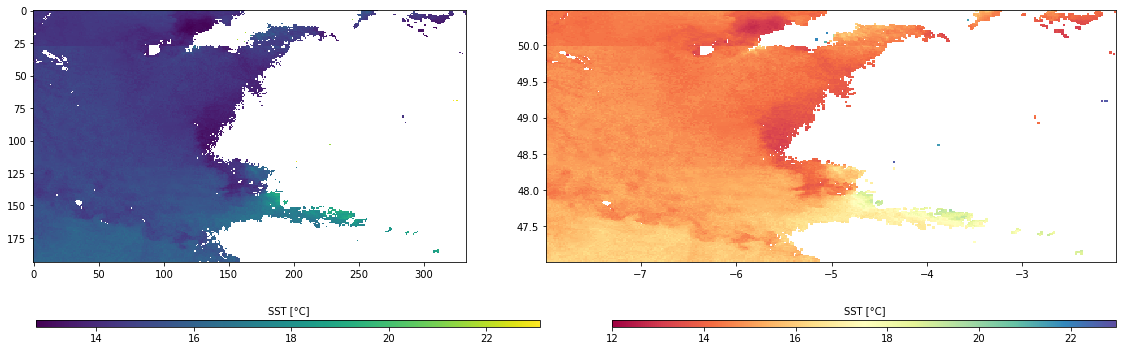

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
im1=ax1.imshow(sst)
im2=ax2.pcolor(lon,lat,sst,cmap=plt.cm.Spectral,vmin=12,vmax=23)

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

wc1,hc1  = 0.35,0.02
xc1,yc1  = 0.15,0.02
cax1    = fig.add_axes([xc1,yc1,wc1,hc1])
cb1     = plt.colorbar(im1,cax1,orientation='horizontal',ticks=np.arange(12,23,2))
cb1.set_label(r'SST [°C]',fontsize=10,labelpad=-38)
cb1.ax.tick_params(labelsize=10)

wc2,hc2  = 0.35,0.02
xc2,yc2  = 0.55,0.02
cax2    = fig.add_axes([xc2,yc2,wc2,hc2])
cb2     = plt.colorbar(im2,cax2,orientation='horizontal',ticks=np.arange(12,23,2))
cb2.set_label(r'SST [°C]',fontsize=10,labelpad=-38)
cb2.ax.tick_params(labelsize=10)

In [7]:
np.shape(sst)

(194, 333)

In [8]:
lonmin,lonmax = np.floor(np.min(lon)),np.ceil(np.max(lon))
latmin,latmax = np.floor(np.min(lat)),np.ceil(np.max(lat))

lonmin,lonmax = -8,-2.
latmin,latmax =47,51.

proj = ccrs.PlateCarree()                            # Choose the projection
cmap = plt.cm.get_cmap('Spectral_r')                 # Choose the colormap

land_10m = cfeature.NaturalEarthFeature(
		category='physical',
		name='land',
		scale='10m',
		edgecolor='k',
		facecolor='lightgrey')
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
        scale='10m',
        edgecolor='gray',
        facecolor='none')
rivers = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        edgecolor='blue',
        facecolor='none')




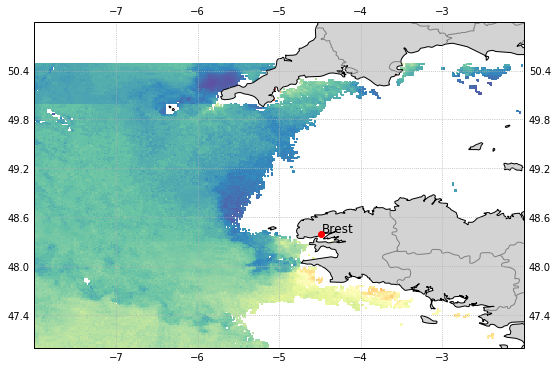

In [42]:
fig = plt.figure(figsize=(10,6))
ax  = plt.axes(projection=proj,extent=[lonmin,lonmax,latmin,latmax])
                       # Land color

# Add coastlines
ax.add_feature(land_10m)
ax.add_feature(rivers)
ax.add_feature(states_provinces)
#ax.add_feature(cfeature.COASTLINE) 
# Add gridlines
ax.gridlines(linestyle=':',draw_labels=True) 

lonbrest=[-4-28/60-59.99/3600]
latbrest=[48+24/60]
city=['Brest']
ax.plot(lonbrest[0],latbrest[0], 'ro', zorder=5,transform=ccrs.PlateCarree())
ax.text(lonbrest[0] + 0.01, latbrest[0] + 0.01, city[0], fontsize='large',transform=ccrs.PlateCarree())

current_cmap = plt.cm.get_cmap('Spectral_r')
ctf = ax.pcolor(lon,lat,sst,cmap=current_cmap)

In [43]:
plt.plot?

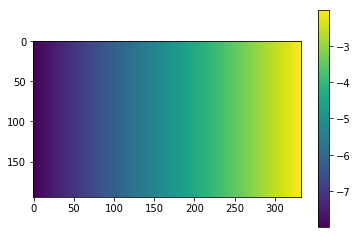

In [44]:
plt.imshow(lon)
plt.colorbar()

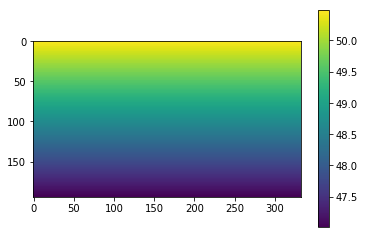

In [45]:
plt.imshow(lat)
plt.colorbar()

## COMPLEX TEXT FILES

In [19]:
file='161201000005.log'
f=open(file, encoding='utf-8',errors='ignore')
line=f.readline()
print(line)


spy udp port 49000



In [7]:
line=f.readline()
print(line)

server: sockfd = 3



In [8]:
line=f.readline()
print(line)

server: bindno = 0



In [13]:
for i in range(10):
    print(f.readline())



161201000005:553865,$WIMWV,61,T,13.0,N,A*3E



161201000005:628161,$WIMWV,87,R,13.2,N,A*32



161201000005:734076,$GPRMC,000005.00,A,27.87,S,45.90,E,5.6,309,011216,,*0B



161201000006:336381,$INGGA,000006.20,2752.44784,S,04554.17051,E,1,14,00.8,016.563,M,0.0,M,0.0,0000*4A



161201000006:336490,$INVTG,300.79,T,306.95,M,005.71,N,010.57,K,D*32



-go back to line 0

In [14]:
f.seek(0)

0

In [15]:
line=f.readline()
print(line)

spy udp port 49000



In [16]:
f.seek(3)
line=f.readline()
print(line)

 udp port 49000



In [20]:
f.close()

In [18]:
print(f.readline())

ValueError: I/O operation on closed file.

-Looping through lines

In [21]:
f=open(file, encoding='utf-8',errors='ignore')
for i in range(6):
    line=f.readline()
    print(line)
f.close()

spy udp port 49000

server: sockfd = 3

server: bindno = 0

161201000005:336240,$INGGA,000005.20,2752.44880,S,04554.17204,E,1,14,00.9,016.565,M,0.0,M,0.0,0000*47



161201000005:336396,$INVTG,300.08,T,306.96,M,005.74,N,010.64,K,D*32



- Retrieving information from one line

In [22]:
f=open(file, encoding='utf-8',errors='ignore')
for i in range(48):
    line=f.readline()

f.close()    
print(line)


161201000007:808868,$MXDBT,6437.45,f,1962.14,M,1072.91,F,*38



In [26]:
line.strip()

'161201000007:808868,$MXDBT,6437.45,f,1962.14,M,1072.91,F,*38'

In [27]:
line.strip().split(':')

['161201000007', '808868,$MXDBT,6437.45,f,1962.14,M,1072.91,F,*38']

In [28]:
line.strip().split(':')[0][:2]

'16'

In [31]:
line.strip().split(':')[1].split(',')

['808868', '$MXDBT', '6437.45', 'f', '1962.14', 'M', '1072.91', 'F', '*38']

In [33]:
line.strip().split(':')[1].split(',')[4]

'1962.14'

In [34]:
float(line.strip().split(':')[1].split(',')[4])

1962.14

In [35]:
type(line)

str

In [36]:
a=[]
a.append(line.strip().split(',')[4])
print(a)

['1962.14']


In [37]:
a=[]
a.append(float(line.strip().split(',')[4]))
print(a)

[1962.14]


In [38]:
if "INGGA" in line:
    print("line is good")

In [62]:
a=[]
a.append(line.strip())
print(a)

['161201000007:808868,$MXDBT,6437.45,f,1962.14,M,1072.91,F,*38']


Go through all the line one by one 

In [39]:
with open(file,encoding='utf-8',errors='ignore') as f:
    for line in f:
        a=line

print(a)


steven@



In [40]:
print(line)

steven@



-Read through all the file (one line after the other)
- And Extract the bathymetry
- Store in a list
- in a numpy array

In [41]:
bathy=[]
bathytime=[]
with open(file,encoding='utf-8',errors='ignore') as f:
    for line in f:
        if "MXDBT" in line:
            bathy.append(float(line.strip().split(',')[4]))
            bathytime.append(line.strip().split(':')[0])

bathy=np.asanyarray(bathy)
print(bathy)


[1962.14 1961.54 1961.73 ... 1757.16 1785.26 1802.2 ]


In [47]:
bathytime[0]

str

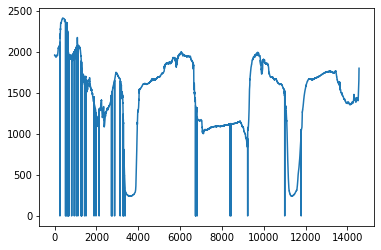

In [49]:
plt.plot(bathy)

# Create a date object

In [50]:
print(bathytime[0])
year=2000+int(bathytime[0][:2])
print(year)
month=int(bathytime[0][2:4])
print(month)
day=int(bathytime[0][4:6])
print(day)
hour=int(bathytime[0][6:8])
print(hour)
minut=int(bathytime[0][8:10])
print(minut)
sec=int(bathytime[0][10:12])
print(sec)

datebathy=datetime(year,month,day,hour,minut,sec)

161201000007
2016
12
1
0
0
7


In [51]:
print(datebathy)
type(datebathy)

2016-12-01 00:00:07


datetime.datetime

In [96]:
bathy=[]
datebathy=[]
with open(file,encoding='utf-8',errors='ignore') as f:
    for line in f:
        if "MXDBT" in line:
            bathy.append(float(line.strip().split(',')[4]))
            bathytime=line.strip().split(':')[0]
            year=2000+int(bathytime[:2])
            month=int(bathytime[2:4])
            day=int(bathytime[4:6])
            hour=int(bathytime[6:8])
            minut=int(bathytime[8:10])
            sec=int(bathytime[10:12])
            datebathy.append(datetime(year,month,day,hour,minut,sec))
            
bathy=np.asanyarray(bathy)
print(bathy)


[1962.14 1961.54 1961.73 ... 1757.16 1785.26 1802.2 ]


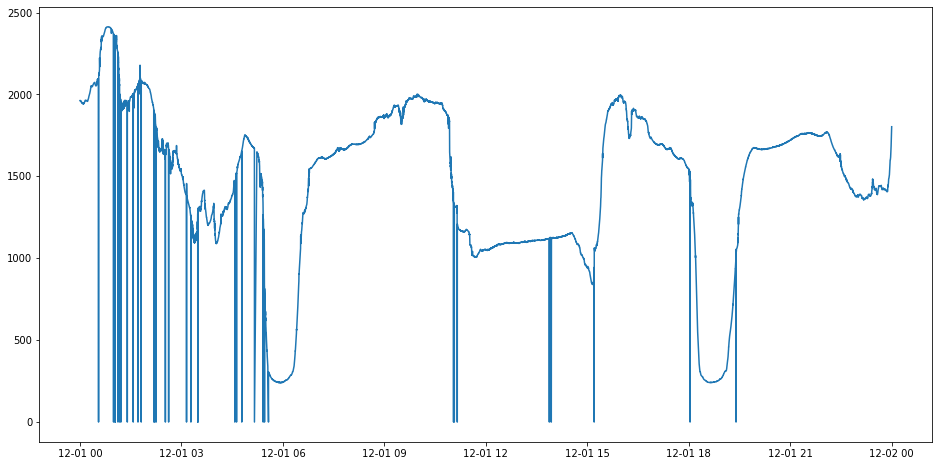

In [59]:
plt.figure(figsize  =(16,8))
plt.plot(datebathy, bathy)

In [53]:
np.empty((1,2),dtype='object')

array([[None, None]], dtype=object)

In [54]:
type(datebathy[0])

datetime.datetime

In [98]:
echobathy=[]
echodate=[]
capdir=[]
capdirtime=[]
gpslat=[]
gpslon=[]
gpsdate=[]
gga=[]
ibat=0
icap=0
igps=0
file='161201000005.log'
NMEA_files=[file]
for filename in NMEA_files:
    print(file)
    file=filename
    with open(file,encoding='utf-8',errors='ignore') as f:
        try:
            for line in f:
                if "MXDBT" in line:
                    echobathy.append(float(line.strip().split(',')[4:5][0]))
                    echotime= line.strip().split(':')[0:1][0]
                    year=2000+int(echotime[:2])
                    month=int(echotime[2:4])
                    day=int(echotime[4:6])
                    hour=int(echotime[6:8])
                    minut=int(echotime[8:10])
                    sec=int(echotime[10:12])
                    echodate.append(datetime(year,month,day,hour,minut,sec))
                    ibat+=1
        except UnicodeDecodeError:
            print('UnicodeDecodeError')
            continue
            
    with open(file,encoding='utf-8',errors='ignore') as f:
        try:
            for line in f:
                if "INVTG" in line:
                    capdir.append(float(line.strip().split(',')[2:3][0]))
                    capdirtime.append(float(line.strip().split(':')[0:1][0]))
                    icap+=1
        except UnicodeDecodeError:
            print('UnicodeDecodeError')
            continue
            
    with open(file,encoding='utf-8',errors='ignore') as f:
        try:
            for line in f:
                if ("INGGA" in line):
                    lattmpdeg=float(line.strip().split(',')[3][:2])
                    lattmpmin=float(line.strip().split(',')[3][2:])
                    lattmpdir=line.strip().split(',')[4]
                    if lattmpdir=='S':
                        gpslat.append(-lattmpdeg-lattmpmin/60.)
                    else:
                        gpslat.append(lattmpdeg+lattmpmin/60.)
                    lontmpdeg=float(line.strip().split(',')[5][:3])
                    lontmpmin=float(line.strip().split(',')[5][3:])
                    lontmpdir=line.strip().split(',')[6]
                    if lontmpdir=='W':
                        gpslon.append(-lontmpdeg-lontmpmin/60.)
                    else:
                        gpslon.append(lontmpdeg+lontmpmin/60.)   
                    gpstime=line.strip().split(':')[0:1][0]
                    year=2000+int(gpstime[:2])
                    month=int(gpstime[2:4])
                    day=int(gpstime[4:6])
                    hour=int(gpstime[6:8])
                    minut=int(gpstime[8:10])
                    sec=int(gpstime[10:12])
                    gpsdate.append(datetime(year,month,day,hour,minut,sec))
                    igps+=1
        except UnicodeDecodeError:
            print('UnicodeDecodeError')
            continue
ngps=ibat
nbathy=igps

161201000005.log


In [103]:
gpsdate[0:13]

[datetime.datetime(2016, 12, 1, 0, 0, 5),
 datetime.datetime(2016, 12, 1, 0, 0, 6),
 datetime.datetime(2016, 12, 1, 0, 0, 7),
 datetime.datetime(2016, 12, 1, 0, 0, 8),
 datetime.datetime(2016, 12, 1, 0, 0, 9),
 datetime.datetime(2016, 12, 1, 0, 0, 10),
 datetime.datetime(2016, 12, 1, 0, 0, 11),
 datetime.datetime(2016, 12, 1, 0, 0, 12),
 datetime.datetime(2016, 12, 1, 0, 0, 13),
 datetime.datetime(2016, 12, 1, 0, 0, 14),
 datetime.datetime(2016, 12, 1, 0, 0, 15),
 datetime.datetime(2016, 12, 1, 0, 0, 16),
 datetime.datetime(2016, 12, 1, 0, 0, 17)]

In [102]:
echodate[:2]

[datetime.datetime(2016, 12, 1, 0, 0, 7),
 datetime.datetime(2016, 12, 1, 0, 0, 12)]

In [64]:
len(gpslon)

86397

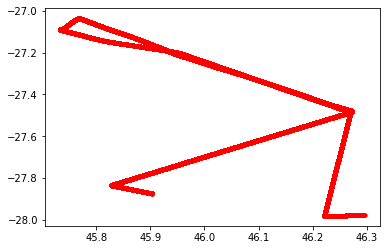

In [65]:
plt.plot(gpslon,gpslat,'r.')

In [91]:
print(np.shape(gpslat))
print(np.shape(echobathy))

(86397,)
(14562,)


In [93]:
def jd_to_date(jd, date_ref):
    date = [date_ref + timedelta(days=x) for x in jd]
    return date

In [94]:
def greg_to_jd(dategreg, dateref):
    tmp = dategreg -dateref
    return np.float(tmp.days) + np.float(tmp.seconds)/86400

In [95]:
dateref = datetime(1950,1,1)

In [104]:
print(echodate[0])

2016-12-01 00:00:07


In [105]:
greg_to_jd(echodate[0],dateref)

24441.00008101852

In [106]:
print(gpsdate[0])

2016-12-01 00:00:05


In [107]:
greg_to_jd(gpsdate[0],dateref)

24441.00005787037

In [110]:
gpsjuld = np.zeros(len(gpsdate))
for it in range(len(gpsdate)):
    gpsjuld[it]= greg_to_jd(gpsdate[it], dateref)
    
echojuld = np.zeros(len(echodate))
for it in range(len(echodate)):
    echojuld[it]= greg_to_jd(echodate[it], dateref)

In [111]:
index_echo_insertinto_gps  = np.searchsorted(gpsjuld, echojuld)

In [112]:
index_echo_insertinto_gps[0]

2

In [113]:
gpslon = np.array(gpslon)
gpslat = np.array(gpslat)

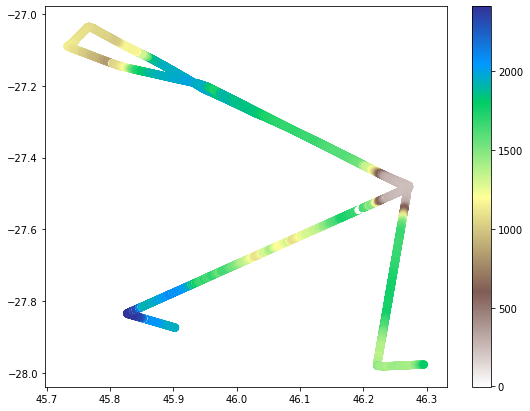

In [121]:
plt.figure(figsize = (9,7))
plt.scatter(gpslon[index_echo_insertinto_gps], gpslat[index_echo_insertinto_gps], s = 50, c = echobathy, cmap=plt.cm.terrain_r)
plt.colorbar()
plt.show()

# plot y as a function of x, x beeing a datetime object

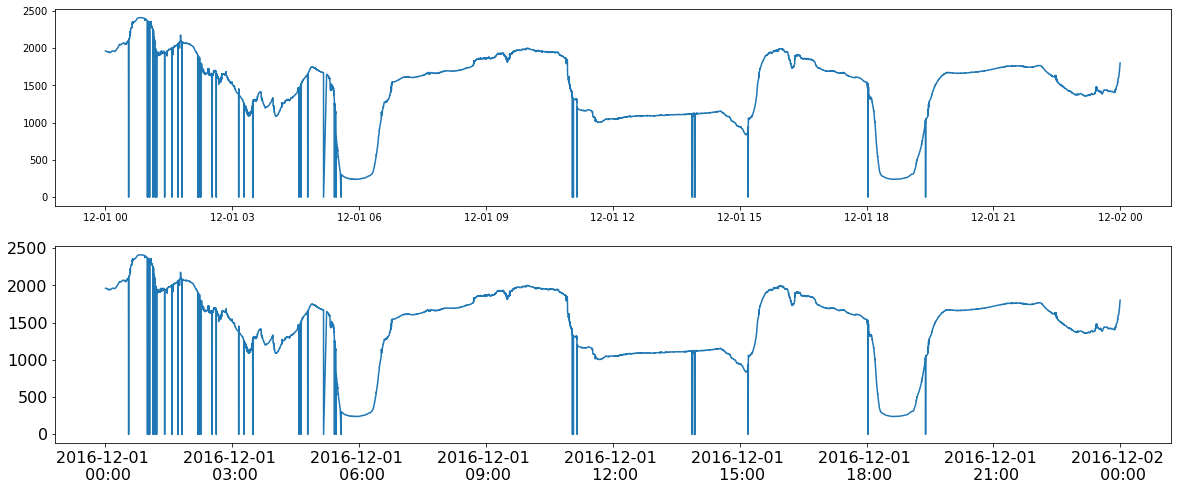

In [60]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(20,8))
ax1.plot(datebathy,bathy)

ax2.plot(datebathy,bathy)
hfmt = mpd.DateFormatter('%Y-%m-%d \n %H:%M')
ax2.xaxis.set_major_formatter(hfmt)



for tickLabel in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    tickLabel.set_fontsize(fontsize = 16)


In [66]:
type(datebathy)

list

In [67]:
bathygood=bathy[bathy>0]
datebathy=np.asanyarray(datebathy)
datebathygood=datebathy[bathy>0]

- Get rid of the bad values

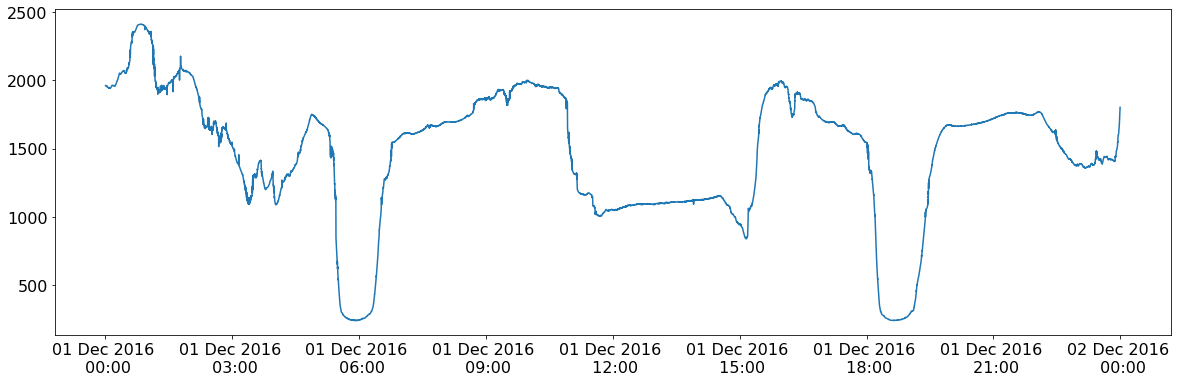

In [68]:


fig,ax=plt.subplots(1,1,figsize=(20,6))
ax.plot(datebathygood,bathygood)

hfmt = mpd.DateFormatter('%Y-%m-%d \n %H:%M')
hfmt = mpd.DateFormatter('%d %b %Y \n %H:%M')
ax.xaxis.set_major_formatter(hfmt)



for tickLabel in (ax.get_xticklabels() + ax.get_yticklabels()):
    tickLabel.set_fontsize(fontsize = 16)


In [69]:
np.median(np.array([0,1,1000,1,5,6]))

3.0

In [70]:
m=5
i=1000
print(bathygood[i-m//2:i+m//2+1])
bathymed=np.zeros_like(bathy)
bathymed[i]=np.median(bathygood[i-m//2:i+m//2+1])

print(bathymed[i])

[2031.74 2035.1  2034.95 2035.09 2036.54]
2035.09


## Running Median filter with size m=5
- Method 1 with loop

In [71]:
m=5
bathymedian=np.zeros_like(bathy)
for i in np.arange(m//2,np.size(bathy)-m//2):
    bathymedian[i]=np.median(bathy[i-m//2:i+m//2+1])

bathymedian[0]=np.median(bathy[:m//2+1])
bathymedian[1]=np.median(bathy[:m//2+2])
bathymedian[-2]=np.median(bathy[-m//2-1:])
bathymedian[-1]=np.median(bathy[-m//2:])

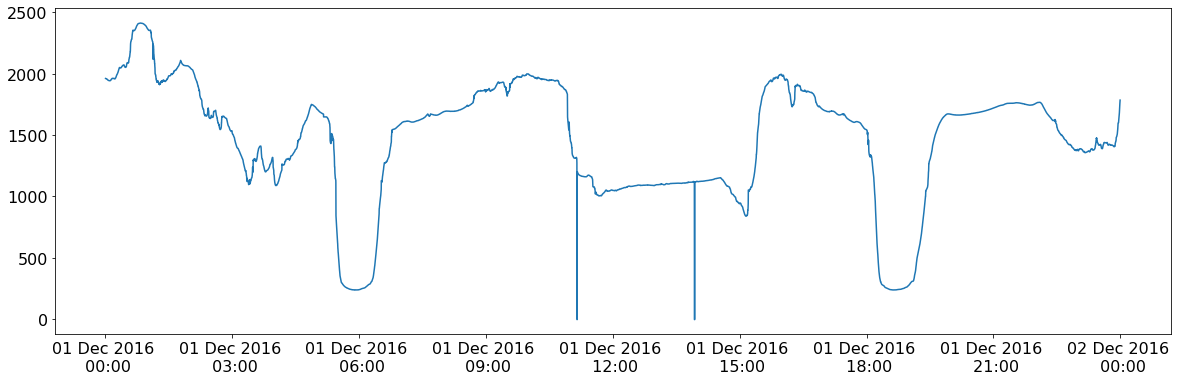

In [72]:
fig,ax=plt.subplots(1,1,figsize=(20,6))
ax.plot(datebathy,bathymedian)

hfmt = mpd.DateFormatter('%Y-%m-%d \n %H:%M')
hfmt = mpd.DateFormatter('%d %b %Y \n %H:%M')
ax.xaxis.set_major_formatter(hfmt)



for tickLabel in (ax.get_xticklabels() + ax.get_yticklabels()):
    tickLabel.set_fontsize(fontsize = 16)

In [73]:
def median_filt1(a,m):
    medianarray=np.zeros_like(a)
    for i in np.arange(m//2,np.size(a)-m//2):
        medianarray[i]=np.median(a[i-m//2:i+m//2+1])
    medianarray[0]=np.median(a[:m//2+1])
    medianarray[1]=np.median(a[:m//2+2])
    medianarray[-2]=np.median(a[-m//2-1:])
    medianarray[-1]=np.median(a[-m//2:])
    return medianarray

In [77]:
timeit(median_filt1(bathy,m=5))

447 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Method 2 

In [78]:
m=5
tmp=np.zeros((m,np.size(bathy)))
tmp[0,:]=bathy
tmp[1,m//2-1:]=bathy[:-1]
tmp[1,:m//2-1]=np.nan
tmp[2,m//2:]=bathy[:-2]
tmp[2,:m//2]=np.nan
tmp[3,:-1]=bathy[1:]
tmp[3,-1]=np.nan
tmp[4,:-2]=bathy[2:]
tmp[4,-2:]=np.nan
bathymedian2=np.median(tmp,axis=0)

                  

In [79]:
tmp[:2]

array([[1962.14, 1961.54, 1961.73, ..., 1757.16, 1785.26, 1802.2 ],
       [    nan, 1962.14, 1961.54, ..., 1746.32, 1757.16, 1785.26]])

In [80]:
def median_filt2(a,m):
    tmp=np.zeros((m,np.size(a)))
    tmp[0,:]=a
    tmp[1,m//2-1:]=a[:-1]
    tmp[1,:m//2-1]=np.nan
    tmp[2,m//2:]=a[:-2]
    tmp[2,:m//2]=np.nan
    tmp[3,:-1]=a[1:]
    tmp[3,-1]=np.nan
    tmp[4,:-2]=a[2:]
    tmp[4,-2:]=np.nan
    return np.median(tmp,axis=0)

In [81]:
timeit(median_filt2(bathy,m=5))

918 µs ± 3.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [82]:
nw=5
m = np.repeat(bathy[np.newaxis,:],nw+1,axis=0)
for i in range(1,nw//2+1):
    m[i,:-i] = m[i,i:]
    m[i,-i:] = np.nan
    m[nw//2+i,i:] = m[nw//2+i,:-i]
    m[nw//2+i,:i] = np.nan

In [83]:
np.max(m[0,:]-bathy)
m[:,:5]

array([[1962.14, 1961.54, 1961.73, 1961.11, 1961.32],
       [1961.54, 1961.73, 1961.11, 1961.32, 1961.08],
       [1961.73, 1961.11, 1961.32, 1961.08, 1959.36],
       [    nan, 1962.14, 1961.54, 1961.73, 1961.11],
       [    nan,     nan, 1962.14, 1961.54, 1961.73],
       [1962.14, 1961.54, 1961.73, 1961.11, 1961.32]])

In [84]:
def homemade_median_filter(x,nw):
    m = np.repeat(x[np.newaxis,:],nw+1,axis=0)
    for i in range(1,nw//2+1):
        m[i,:-i] = m[i,i:]
        m[i,-i:] = np.nan
        m[nw//2+i,i:] = m[nw//2+i,:-i]
        m[nw//2+i,:i] = np.nan
        
    m[-1,:] = np.nanmedian(m[:-1,:],axis=0)
    return m[-1]

In [85]:
bathymedian3=homemade_median_filter(bathy,nw=5)

In [87]:
timeit(homemade_median_filter(bathy,nw=5))

2.3 ms ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
from scipy import signal
bathymedian4=signal.medfilt(bathy,5)

In [90]:
timeit(signal.medfilt(bathy,5))

4.41 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [157]:
signal.medfilt?

In [152]:
print(tmp[:,:5])

[[ 1962.14  1961.54  1961.73  1961.11  1961.32]
 [     nan  1962.14  1961.54  1961.73  1961.11]
 [     nan      nan  1962.14  1961.54  1961.73]
 [ 1961.54  1961.73  1961.11  1961.32  1961.08]
 [ 1961.73  1961.11  1961.32  1961.08  1959.36]]


In [119]:
print(tmp[:,-5:])

[[ 1732.01  1746.32  1757.16  1785.26  1802.2 ]
 [ 1707.19  1732.01  1746.32  1757.16  1785.26]
 [ 1683.28  1707.19  1732.01  1746.32  1757.16]
 [ 1746.32  1757.16  1785.26  1802.2       nan]
 [ 1757.16  1785.26  1802.2       nan      nan]]


In [96]:
m=5
m//2

2

In [97]:
np.size(bathy)-m//2

14560

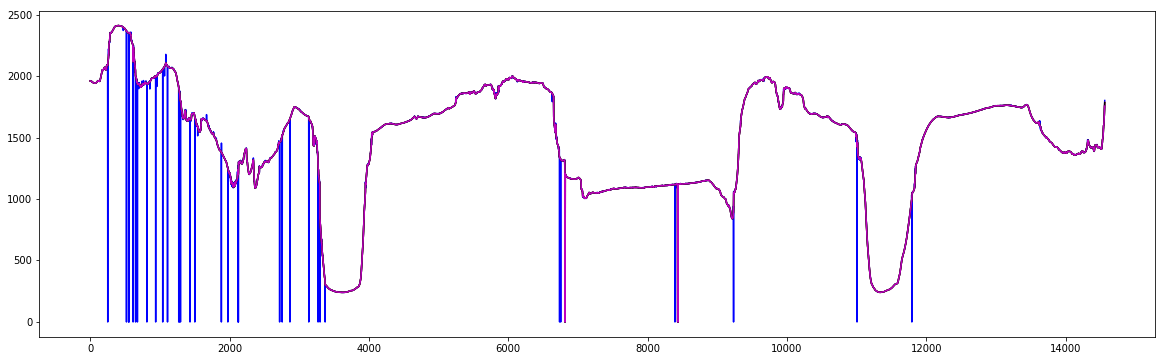

In [145]:
fig,ax=plt.subplots(1,1,figsize=(20,6))
ax.plot(bathy,'b-')
ax.plot(bathymedian,'r-')
ax.plot(bathymedian2,'g-')
ax.plot(bathymedian3,'k-')
ax.plot(bathymedian4,'m-')

In [167]:
np.max(np.abs(bathymedian4-bathymedian)
       [~np.isnan(np.abs(bathymedian4-bathymedian))])

28.099999999999909

In [108]:
np.median?

In [124]:
bathymedian[2]-bathymedian2[2]

0.095000000000027285

In [126]:
i=2
bathy[i-m//2:i+m//2+1]

array([ 1962.14,  1961.54,  1961.73,  1961.11,  1961.32])